### Test Torch Data Loader Transforms

##### Imports and functions needed

In [74]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets.folder import default_loader
from torchvision import transforms
from random import uniform
import numpy as np
from PIL import Image
from math import tan
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


class RetinopathyDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None, loader=default_loader):
        self.root_dir = Path(root_dir) if type(root_dir) is str else root_dir
        self.image_names = list(self.root_dir.glob('*.jpeg'))
        self.transform = transform
        if csv_file:
            labels = pd.read_csv(csv_file)
            self.labels = dict(zip(list(labels.image), list(labels.level)))
        else:
            self.labels = None
        self.loader = loader

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_path = self.image_names[index]
        image = self.loader(image_path)
        if self.transform:
            image = self.transform(image)

        if self.labels:
            label = self.labels[image_path.stem]
            return image, label
        else:
            return image, image_path.stem


# customization of https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
def get_dataset(data_dir,
                           label_path,
                           batch_size,
                           train_transforms,
                           valid_transforms,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=4,
                           pin_memory=False, get_dataset_objects=False):
    
    return RetinopathyDataset(data_dir, label_path, train_transforms)

# Function to implement skew based on PIL transform

def skew_image(img, angle, inc_width=False):
    """
    Skew image using some math
    :param img: PIL image object
    :param angle: Angle in radians (function doesn't do well outside the range -1 -> 1, but still works)
    :return: PIL image object
    """
    width, height = img.size
    # Get the width that is to be added to the image based on the angle of skew
    xshift = tan(abs(angle)) * height
    new_width = width + int(xshift)

    if new_width < 0:
        return img

    # Apply transform
    img = img.transform(
        (new_width, height),
        Image.AFFINE,
        (1, angle, -xshift if angle > 0 else 0, 0, 1, 0),
        Image.BICUBIC
    )
    
    if (inc_width):
        return img
    else:
        return img.crop((0, 0, width, height))
    

def plot_images(images):
    plt.figure(figsize=(10, 10))
    columns = 2
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

## Enter Desired Transforms here

In [91]:
train_data_transforms = transforms.Compose([
    
    transforms.Lambda(lambda x: x.rotate(uniform(0,360), resample=Image.BICUBIC)),  # random rotation 0 to 360
    transforms.Lambda(lambda x: skew_image(x, uniform(-0.2, 0.2), inc_width=True)), # random skew +- 0.2
    transforms.RandomResizedCrop(250, scale=(0.9, 1.1), ratio=(1,1)),               # scale +- 10%, resize to 300
    transforms.CenterCrop((224))                                                    # take 224x224 center crop
    #transforms.ToTensor() # commented to get the images as PIL Image object
])

### Enter train data path here

In [92]:

data_params = {
    'train_path': '../data/train_300',
    'test_path': '../data/test',
    'label_path': '../data/trainLabels.csv',
    'batch_size': 1,
    'submission_file': '../data/submission.csv'
}


### Enter number of sample images to plot (n)

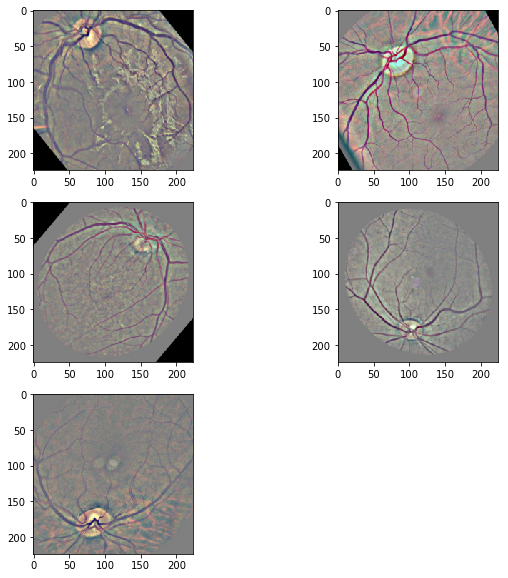

In [95]:
# Enter n here

n = 5


images = []
train_dataset = get_dataset(data_params['train_path'], data_params['label_path'],
                            random_seed=54321, batch_size=data_params['batch_size'],
                            train_transforms=train_data_transforms,valid_transforms=train_data_transforms)


images = [train_dataset[i][0] for i in range(n)]
plot_images(images)